In [1]:
# import packages that will be used for plotting and analyzing the data

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
%matplotlib inline

from sklearn.metrics import mean_squared_log_error

from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, RobustScaler


In [2]:
df = pd.read_csv('Data/train_imputed.csv')

In [3]:
X = df.drop('SalePrice', axis=1)
y = df.SalePrice

In [4]:
X.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.2,-0.265787,-0.254076,0.0,0.0,0.5,0.0,0.652174,0.243243,1.193303,...,0,0,0,1,0,0,0,0,1,0
1,-0.6,0.523686,0.030015,0.0,0.0,0.0,3.0,0.065217,-0.486486,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,0.2,-0.107893,0.437624,-1.0,0.0,0.5,0.0,0.608696,0.216216,0.986301,...,0,0,0,1,0,0,0,0,1,0
3,0.4,-0.528945,0.017663,-1.0,0.0,0.5,0.0,-1.260870,-0.648649,0.000000,...,0,0,0,1,1,0,0,0,0,0
4,0.2,0.734213,1.181201,-1.0,0.0,1.0,0.0,0.586957,0.162162,2.130898,...,0,0,0,1,0,0,0,0,1,0


In [5]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [6]:
def rmsle2(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

# Linear Regression with PCA

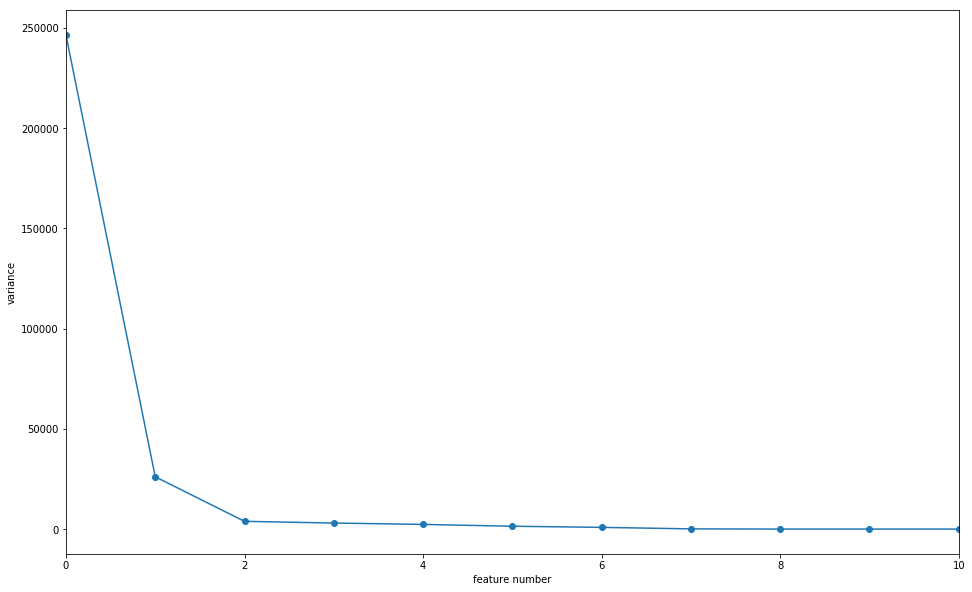

In [7]:
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)
plt.figure(figsize=(16, 10))
plt.plot(features, pca.explained_variance_, '-o')

plt.xlabel('feature number')
plt.ylabel('variance')
plt.xlim(0, 10)
plt.show()

In [8]:
model=PCA(n_components=2)
model.fit(X)
df_components = pd.DataFrame(model.transform(X))
df_components.columns = ['component1', 'component2']

In [9]:
df_PCA = df_components.join(y, how='left')

X_train, X_test, y_train, y_test = train_test_split(df_components, y, test_size=0.3, random_state=10)


In [10]:
reg_PCA = LinearRegression()
reg_PCA.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}

In [13]:
reg_PCA_cv = GridSearchCV(reg_PCA, param_grid, cv=5)
reg_PCA_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
print("Tuned Regression Parameter: {}".format(reg_PCA_cv.best_params_))
print("Tuned Regression Accuracy: {}".format(reg_PCA_cv.best_score_))

Tuned Regression Parameter: {'fit_intercept': True, 'normalize': True}
Tuned Regression Accuracy: -0.00401923118734091


In [15]:
reg_PCA = LinearRegression(reg_PCA_cv.best_params_)
reg_PCA.fit(X_train, y_train)

LinearRegression(copy_X=True,
         fit_intercept={'fit_intercept': True, 'normalize': True},
         n_jobs=1, normalize=False)

In [16]:
y_pred_PCA = reg_PCA.predict(X_test)

pca_rmsle = rmsle(y_test, y_pred_PCA)
print('PCA Score:', pca_rmsle)

0.030868884371185082

In [17]:
rmsle2(y_test, y_pred_PCA)

0.030868884371185068

# Linear Regression (out of box)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [19]:
reg_oob = LinearRegression()
reg_oob.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
reg_oob.score(X_train, y_train)

0.94658394393416934

In [21]:
y_pred_reg_oob = reg_oob.predict(X_test)

reg_rmsle = rmsle(y_test, y_pred_reg_oob)
print('LinReg Score: ', reg_rmsle)

0.0093180220676094098

# Linear Regression with VIF

In [22]:
# from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class/code

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [23]:
transformer = ReduceVIF()
X = transformer.fit_transform(X, y)

ReduceVIF fit
ReduceVIF transform


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping BsmtFinSF1 with vif=inf
Dropping 1stFlrSF with vif=inf
Dropping MSZoning_C (all) with vif=inf
Dropping Street_Grvl with vif=inf
Dropping Alley_Grvl with vif=inf
Dropping LandContour_Bnk with vif=inf
Dropping Utilities_AllPub with vif=inf
Dropping LotConfig_Corner with vif=inf
Dropping Neighborhood_Blmngtn with vif=inf
Dropping Condition1_Artery with vif=inf
Dropping Condition2_Artery with vif=inf
Dropping BldgType_1Fam with vif=inf
Dropping HouseStyle_1.5Fin with vif=inf
Dropping RoofStyle_Flat with vif=inf
Dropping RoofMatl_CompShg with vif=inf
Dropping Exterior1st_AsbShng with vif=inf
Dropping Exterior1st_CBlock with vif=inf
Dropping Exterior2nd_AsbShng with vif=inf
Dropping MasVnrType_BrkCmn with vif=inf
Dropping Foundation_BrkTil with vif=inf
Dropping Heating_Floor with vif=inf
Dropping Electrical_FuseA with vif=inf
Dropping GarageType_2Types with vif=inf
Dropping Fence_GdPrv with vif=inf
Dropping MiscFeature_Gar2 with vif=inf
Dropping SaleType_COD with vif=inf
Dropping Sa

C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1388: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Dropping MiscFeature_None with vif=4365.1712836591305
Dropping GarageYrBlt with vif=2232.9888815104828
Dropping Heating_GasA with vif=1080.536772688213
Dropping Condition2_Norm with vif=721.6011720244313
Dropping RoofStyle_Gable with vif=439.2597024224827
Dropping Street_Pave with vif=318.84317717626016
Dropping Exterior1st_VinylSd with vif=170.8732506889865
Dropping MSZoning_RL with vif=158.58315459641068
Dropping GarageType_Attchd with vif=126.08657720027163
Dropping MasVnrType_None with vif=62.151741101657336
Dropping SaleType_New with vif=52.04978235758153
Dropping Exterior2nd_MetalSd with vif=50.22142901263269
Dropping Alley_None with vif=42.40460934677041
Dropping 2ndFlrSF with vif=36.69069788633362
Dropping SaleType_WD with vif=34.43328323256324
Dropping Condition1_Norm with vif=34.1655100518604
Dropping MSSubClass with vif=32.8237883342591
Dropping LandContour_Lvl with vif=29.079481465828596
Dropping Exterior2nd_CmentBd with vif=27.25478552644733
Dropping Fence_None with vif=25

In [24]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 162 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(162)
memory usage: 1.8 MB


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [26]:
reg_VIF = LinearRegression()
reg_VIF.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
reg_VIF.score(X_train, y_train)

0.91456801678784505

In [28]:
y_pred_reg_VIF = reg_VIF.predict(X_test)

regvif_rmsle = rmsle(y_test, y_pred_reg_VIF)
print('LinReg VIF Score: ', regvif_rmsle)

0.010949409415825081

In [29]:
reg_cv = GridSearchCV(reg_VIF, param_grid, cv=5)
reg_cv.fit(X_train,y_train)

print("Tuned Logistic Regression Parameter: {}".format(reg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(reg_cv.best_score_))

Tuned Logistic Regression Parameter: {'fit_intercept': True, 'normalize': False}
Tuned Logistic Regression Accuracy: 0.8541816478674551


# Lasso Regression

In [37]:
reg_lasso = Lasso()
reg_lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
y_pred_reg_lasso = reg_lasso.predict(X_test)

rmsle(y_test, y_pred_reg_lasso)

0.030315304617240489

In [ ]:
param_grid = {'alpha':[0.1, 1, 10], 'normalize':[True, False]}

In [ ]:
reg_lasso_cv = GridSearchCV(reg_lasso, param_grid, cv=5)
reg_lasso_cv.fit(X_train, y_train)

In [ ]:
y_pred_reg_lasso = reg_lasso.predict(X_test)

lasso_rmsle = rmsle(y_test, y_pred_reg_lasso)
print("Lasso Score: ", lasso_rmsle)

# Random Forest

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [40]:
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [41]:
y_pred_reg_rf = reg_rf.predict(X_test)

rmsle(y_test, y_pred_reg_rf)

0.012747902764317368

In [42]:
# Specify the hyperparameters to be tested with RandomizedSearchCV

# Number of trees in random forest
n_estimators = [120, 300, 500, 800, 1200]

# Number of features to consider at every split
max_features = ['log2', 'sqrt', 'auto']

# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30, None]

# Minimum number of samples required to split a node
min_samples_split = [1.0, 2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X, y)

In [43]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
reg_rf_cv = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=10, n_jobs = -1)

# Fit the random search model
reg_rf_cv.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.5min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_features': ['log2', 'sqrt', 'auto'], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [1.0, 2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=10, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [46]:
print(reg_rf_cv.best_params_)
print(reg_rf_cv.best_score_)

{'n_estimators': 120, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 25, 'bootstrap': True}
0.848971711276


In [52]:
reg_rf_tuned = RandomForestRegressor(n_estimators=120, min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=25, bootstrap=True)
reg_rf_tuned.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [53]:
y_pred_reg_rf_tuned = reg_rf_tuned.predict(X_test)

rf_rmsle = rmsle(y_test, y_pred_reg_rf_tuned)
print('RF Score: ', rf_rmsle)

0.011591843676481035

# XGBoost

In [54]:
reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
reg_xgb.score(X_train, y_train)

0.93799504509558307

In [56]:
y_pred_xgb = reg_xgb.predict(X_test)

rmsle(y_test, y_pred_xgb)

0.01081547751063347

In [57]:
# Test Parameters
eta = [0.01, 0.015, 0.025, 0.05, 0.1]
gamma = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
max_depth = [3, 5, 7, 9, 12, 15, 17, 25]
min_child_weight = [1, 3, 5, 7]
subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bytree = [0.6, 0.7, 0.8, 0.9, 1.0]
lamb = [0.01, 0.1, 1.0]
alpha = [0, 0.1, 0.5, 1.0]

# Create the random grid
param_grid = { 'gamma': gamma,
               'max_depth': max_depth, 
               'min_child_weight': min_child_weight, 
               'subsample': subsample, 
               'colsample_bytree': colsample_bytree}

In [ ]:
reg_xgb_cv = GridSearchCV(reg_xgb,
                        param_grid,
                        cv = 5,
                        n_jobs = 2,
                        verbose=True)
reg_xgb_cv.fit(X_train,y_train)

Fitting 5 folds for each of 5600 candidates, totalling 28000 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   22.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   47.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  6.8min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 10.4min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 14.9min
[Parallel(n_jobs=2)]: Done 3196 tasks      | elapsed: 19.5min
[Parallel(n_jobs=2)]: Done 4046 tasks      | elapsed: 24.4min
[Parallel(n_jobs=2)]: Done 4996 tasks      | elapsed: 29.5min
[Parallel(n_jobs=2)]: Done 6046 tasks      | elapsed: 35.6min
[Parallel(n_jobs=2)]: Done 7196 tasks      | elapsed: 44.0min
[Parallel(n_jobs=2)]: Done 8446 tasks      | elapsed: 51.3min
[Parallel(n_jobs=2)]: Done 9796 tasks      | elapsed: 60.5min
[Parallel(n_jobs=2)]: Done 11246 tasks      | elapsed: 70.7min
[Parallel(n_jobs=2)]: Done 12796 tasks      | elapsed: 82.3min
[Parallel(

In [ ]:
reg_xgb.get_params().keys()

In [ ]:
print("Tuned Logistic Regression Parameter: {}".format(reg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(reg_cv.best_score_))